In [50]:
from math import sqrt
from numpy import concatenate
from numpy import array
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [51]:
import pandas as pd
from matplotlib import pyplot
import datetime

conso = pd.read_csv('./Data/conso_train.csv', sep=';')
conso.date = pd.to_datetime(conso.date)
#On ajoute une seconde à la date car elle est sous la forme 22:59:59 jusqu'à fin décembre
conso.date = conso.date + datetime.timedelta(0,1); 
conso.index = conso.date
#Puis elle est sous la forme 22:00:00 à partir de début 2016 donc on re-rajoute une seconde à partir de là
conso2 = conso[2642:]
conso2.date = conso2.date - datetime.timedelta(0,1);
conso[2642:] = conso2;
conso = conso.drop(['date'], axis=1)

meteo = pd.read_csv('./Data/meteo_train.csv', sep=';', usecols=['Date UTC', 'T¬∞ (C)', 'P (hPa)', 'HR (%)', 'P.ros√©e (¬∞C)', 'Visi (km)', 'Vt. moy. (km/h)','Vt. raf. (km/h)', 'Vt. dir (¬∞)','RR 3h (mm)','Neige (cm)','Nebul. (octats)'])
meteo.columns = ['date','temp','pression','hr','pros','visi','vmoy','vraf','vdir','rr','neige','nebul']
#Pour éviter les glitchs sur la date de météo
meteo.date = meteo.date.str.replace('h', ':')
meteo.date = pd.to_datetime(meteo.date, format='%d/%m/%y %H:%M')
meteo.date = meteo.date.dt.strftime('%Y-%m-%d %H:%M:%S')
meteo.index = meteo.date
meteo = meteo.drop(['date'], axis=1);
#display(meteo.head())

df = pd.merge(conso, meteo, right_index = True, left_index = True)
df = df.drop(['rr'], axis=1)
df = df.drop(['neige'], axis=1)
df = df.drop(['nebul'], axis=1)


df = df.dropna()
values = df.values

# Meteo : 2928 lignes de données
# Conso : 8760 lignes de données
# 878 ignes car il ne merge que du début du fichier jusqu'à fin décembre 2015

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
display(values.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1, dropnan=False)

# drop columns we don't want to predict : on veut que les var(t-1) on drop donc les var(t)
# LEs var t-1 correspondent aux inputs (toutes les colonnes) et les var t qu'on garde aux outputs que l'on souhaite (ici var1 t suelement car on veut la pollution)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

reframed = reframed.dropna()
display(reframed.tail())
values = reframed.values

n_train_hours = 2803 #Timestamp('2016-09-05 21:00:00')
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(2860, 9)

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2855   0.076600   0.600610   0.556281   0.901408   0.952607   0.833333   
2856   0.168590   0.637195   0.562806   0.845070   0.976303   0.750000   
2857   0.216276   0.710366   0.557912   0.690141   0.985782   0.483333   
2858   0.072869   0.719512   0.536704   0.619718   0.952607   0.583333   
2859   0.161245   0.655488   0.531812   0.746479   0.943128   0.833333   

      var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
2855   0.388889   0.381818   0.527778  0.168590  
2856   0.361111   0.345455   0.500000  0.216276  
2857   0.416667   0.381818   0.527778  0.072869  
2858   0.416667   0.381818   0.527778  0.161245  
2859   0.277778   0.272727   0.527778  0.144922

(2803, 1, 9) (2803,) (56, 1, 9) (56,)


Train on 2803 samples, validate on 56 samples
Epoch 1/50
 - 1s - loss: 0.2309 - val_loss: 0.2376
Epoch 2/50
 - 0s - loss: 0.1730 - val_loss: 0.1620
Epoch 3/50
 - 0s - loss: 0.1607 - val_loss: 0.1422
Epoch 4/50
 - 0s - loss: 0.1467 - val_loss: 0.1224
Epoch 5/50
 - 0s - loss: 0.1313 - val_loss: 0.0988
Epoch 6/50
 - 0s - loss: 0.1166 - val_loss: 0.0811
Epoch 7/50
 - 0s - loss: 0.1052 - val_loss: 0.0690
Epoch 8/50
 - 0s - loss: 0.0994 - val_loss: 0.0676
Epoch 9/50
 - 0s - loss: 0.0966 - val_loss: 0.0670
Epoch 10/50
 - 0s - loss: 0.0956 - val_loss: 0.0664
Epoch 11/50
 - 0s - loss: 0.0949 - val_loss: 0.0661
Epoch 12/50
 - 0s - loss: 0.0945 - val_loss: 0.0658
Epoch 13/50
 - 0s - loss: 0.0943 - val_loss: 0.0657
Epoch 14/50
 - 0s - loss: 0.0942 - val_loss: 0.0658
Epoch 15/50
 - 0s - loss: 0.0939 - val_loss: 0.0657
Epoch 16/50
 - 0s - loss: 0.0938 - val_loss: 0.0655
Epoch 17/50
 - 0s - loss: 0.0937 - val_loss: 0.0655
Epoch 18/50
 - 0s - loss: 0.0937 - val_loss: 0.0656
Epoch 19/50
 - 0s - loss: 0

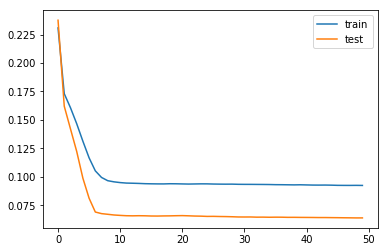

In [52]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.legend()
pyplot.show()

Test RMSE: 109.177


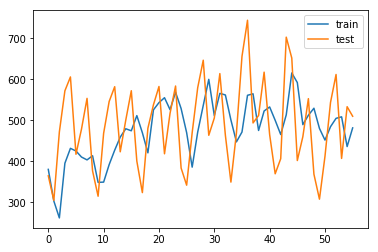

In [53]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


pyplot.plot(inv_yhat, label='train')
pyplot.plot(inv_y,  label='test')
pyplot.legend()
pyplot.show()